# Quick start
 
For example, we  use the spatial expression matrix of Bin1 of Stereo-Seq in the mouse olfactory bulb for the use of **stereopy** tools for downstream analysis.

There are two types of Stereo-seq data, gem and gef. The format of the original expression matrix of gem file is as follows: x, y are the spatial position of the gene in the tissue section, and count is the number of gene expression.

|  GeneID   | x | y | count |
|  ----  | ----  | ----| ----|
| Gene1  | 121 | 200 | 2 |
| Gene2  | 234 | 300 | 1 |
| ...  | ... | ... | ... |
| Gene n | 234 | 300 | 1 |

The detail information of gef file is in the [documentation](https://www.processon.com/view/link/610cc49c7d9c087bbd1ab7ab#map).Here, we recommend using the format of gef, the reading speed is much faster than gem.

## Read the raw data of Stereo-Seq

The resolution of Stereo-Seq sequencing technology is up to nanometer level. The nanopore radius of Bin1 is 250 nm. 

Generally, the **bin_size** parameter is set to combine the nanopores within a certain range into a bin unit for analysis. tthe side length of the bin unit is approximately 14 microns when **bin_size** is set to 20.

After merging according to a certain **bin_size**, we will uniformly generate the data into the format of StereoExpData, which is designed for the analysis.

In addition, stereopy can support reading 10x data, as detailed in the API documentation.

In [29]:
import warnings

warnings.filterwarnings('ignore')
import stereo as st

!mkdir stereo_demo
!cd stereo_demo
!git clone https://github.com/BGIResearch/stereopy_data.git
!cd stereopy_data/mouse

In [30]:
mouse_data_path = '/ldfssz1/ST_BI/USER/huangzhibo/workitems/DP8400013846TR_F5_out_new/stereomics.h5'
data = st.io.read_gef(file_path=mouse_data_path, bin_size=50)

2021-12-02 17:41:15 Stereo INFO: read_gef begin ...
2021-12-02 17:41:16 Stereo INFO: the martrix has 13129 cells, and 28553 genes.
2021-12-02 17:41:17 Stereo INFO: read_gef end.


## Preprocessing

Data preprocessing includes three modules: **Quality control**, **Filtering** and **Normalization**.

### Quality control

The quality control module mainly calculates the data quality distribution of the original data, and mainly counts three indicators:
- the number of genes expressed in the count matrix. (n_genes_by_counts)
- the total counts per cell. (total_counts)
- the percentage of counts in mitochondrial genes. (pct_counts_mt)

In [31]:
data.tl.cal_qc()

Show the violin figure of the qc distribution.

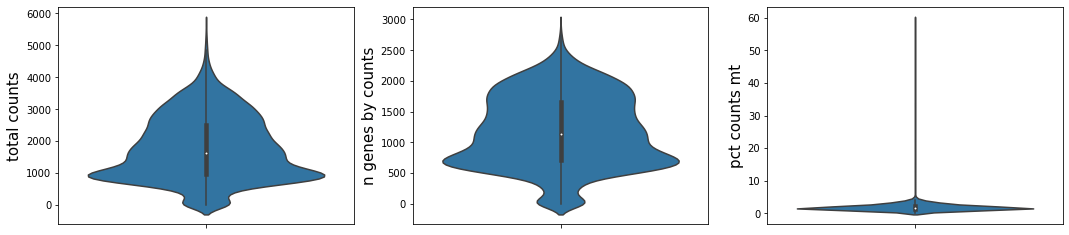

In [32]:
data.plt.violin()

Show the spatial scatter figure of the qc distribution.

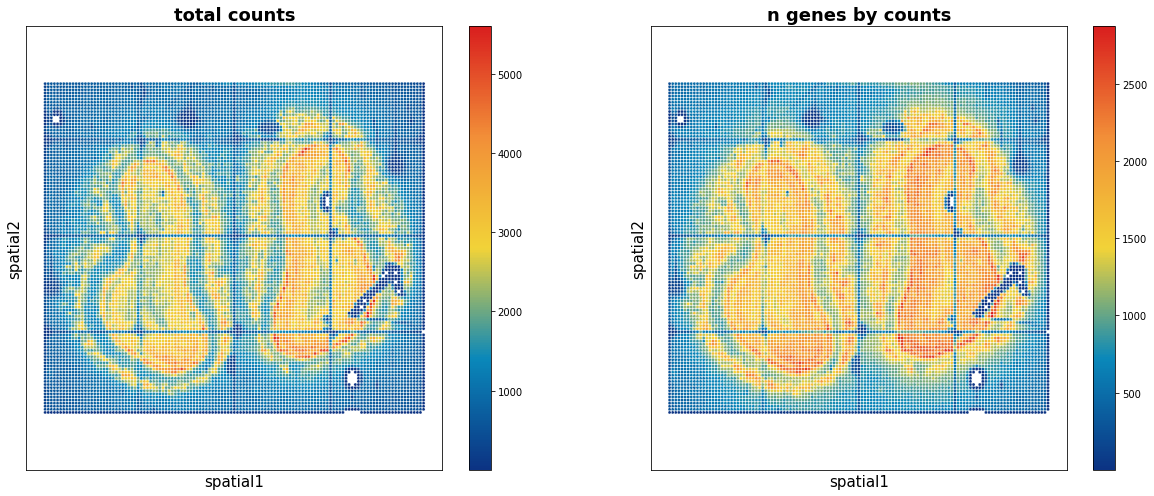

In [33]:
data.plt.spatial_scatter()

### Filtering

Generally, we will filter the `bin unit` based on the three quality control indicators total_count, n_genes_by_counts and pct_counts_MT.

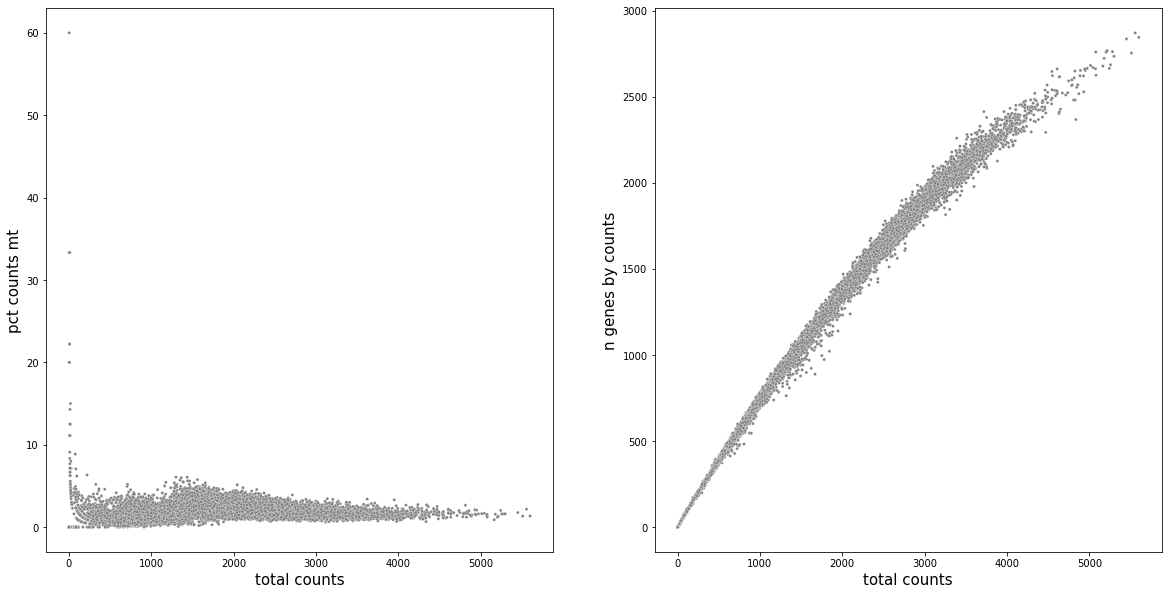

In [34]:
data.plt.genes_count()

In [35]:
data.tl.filter_cells(min_gene=200, min_n_genes_by_counts=3, max_n_genes_by_counts=6000, 
                     pct_counts_mt=5, inplace=True)

In addition, we also provide `data.tl.filter_genes` function to filter genes and `data.tl.filter_coordinates` function to filer bin unit by its coordinate.

For detailed instructions, please refer to its api document.

### hvg



We use raw data to find hvg, and this set of hvg will be used in data.tl.spatial_hotspot()

In [36]:
data.tl.highly_variable_genes(min_mean=0.0125, max_mean=3,min_disp=0.5,
                              n_top_genes=2000, res_key='raw_highly_variable_genes')
                              

### Normalization

In this module, we mainly provide four common standardization methods.

- normalize_total
- quantile
- zscore_disksmooth
- scTransform

If the parameter `inplace` is set to True, data.exp_matrix will be replaced with the normalized result, otherwise unchanged. You can save the raw exp_matrix by `data.tl.raw_checkpoint()`.

In [37]:
data.tl.raw_checkpoint()

Run the scTransform normalization method.You can set the `res_key` for save the result. the express matrix will be replaceed by the sctranform result if `inplace` is True.

In [38]:
data.tl.sctransform(res_key='sctransform', inplace=True)

### hvg

In [39]:
data.tl.highly_variable_genes(min_mean=0.0125, max_mean=3,min_disp=0.5,
                              n_top_genes=2000, res_key='highly_variable_genes')

 In addition, we also provide `data.tl.normalize_total`, `data.tl.quantile`, `data.tl.zscore_disksmooth` function for normalization.

## PCA

By default, PCA is used to reduce dimensionality. 

In [40]:
data.tl.pca(use_highly_genes=False, n_pcs=30, res_key='pca')

## Neighborhood graph

After PCA, we compute the neighborhood graph of cells using the PCA representation of the expression matrix. 

In [41]:
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors')

Embedding the graph in two dimensions using UMAP.

In [42]:
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap')

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


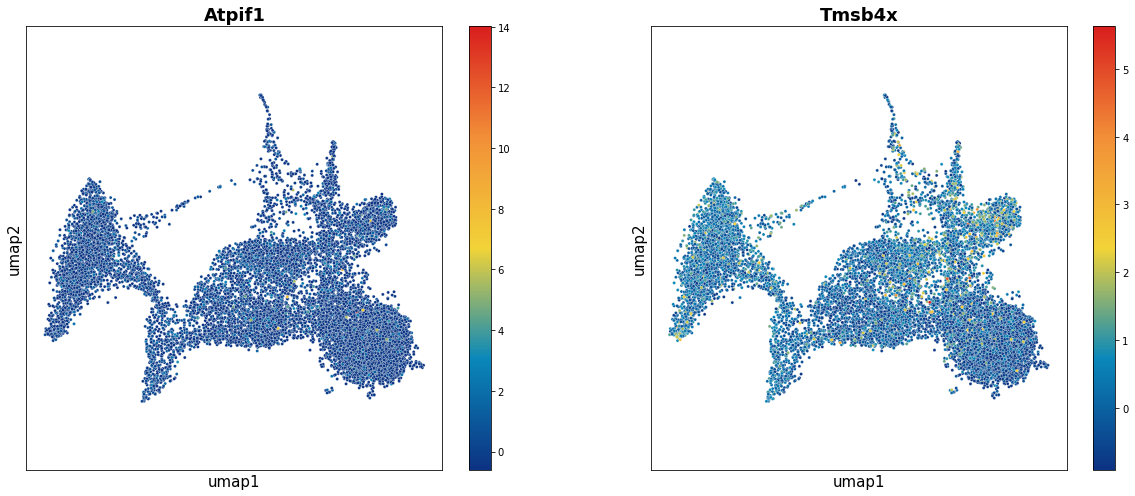

In [43]:
fig = data.plt.umap(gene_names=['Atpif1', 'Tmsb4x'], res_key='umap')

## Spatial neighborhood graph


If you want to use spatial information in clustering calculation, in this function we provide "squidpy" to build a new adjacency matrix using position information and combine it with the old adjacency matrix from last step to do the calculation.

In [44]:
data.tl.spatial_neighbors(neighbors_res_key="neighbors",res_key="spatial_neighbors")

## Clustering

Currently we provide three common clustering methods, including **phenograph**, **leiden** and **louvain**. 

In this tool, you can re-run the normalization method before clustering if the `normalize_method` parameter is not None. Then by default, we use pca to reduce the dimensionality of the new normalization method, and then using the top 30 pcs to run clustering.

### leiden

In [45]:
data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

Show the spatial distribution of the clusering result.

<AxesSubplot:>

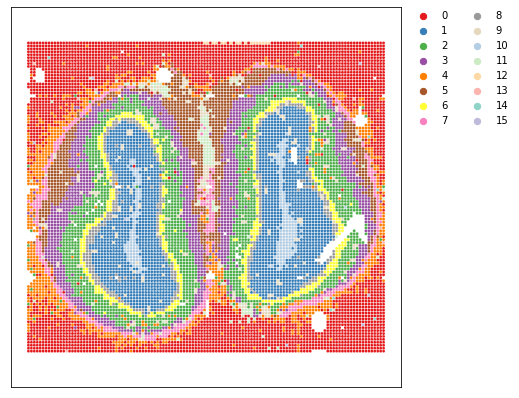

In [46]:
data.plt.cluster_scatter(res_key='leiden')

### leiden ( using spatial_neighbors )

It can also show the umap spatial distribution of the clustering result.

<AxesSubplot:title={'center':'leiden'}, xlabel='umap1', ylabel='umap2'>

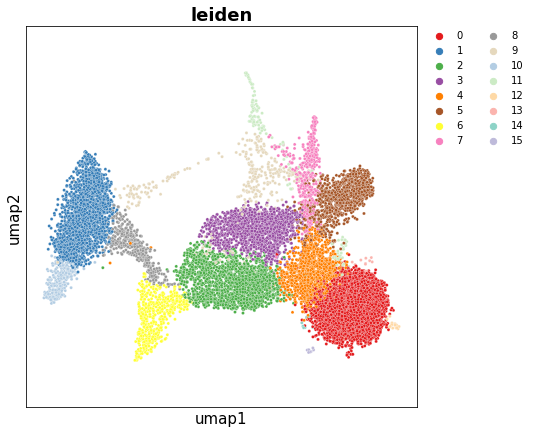

In [47]:
data.plt.umap(res_key='umap', cluster_key='leiden')

cluster using spatial information.

In the part, we use the neighbors from data.tl.spatial_neighbors for clustering.

In [48]:
data.tl.leiden(neighbors_res_key="spatial_neighbors",res_key="spatial_leiden")

<AxesSubplot:>

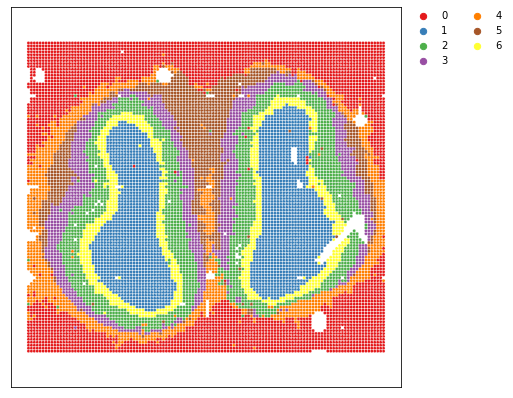

In [49]:
data.plt.cluster_scatter(res_key="spatial_leiden")

<AxesSubplot:title={'center':'spatial_leiden'}, xlabel='umap1', ylabel='umap2'>

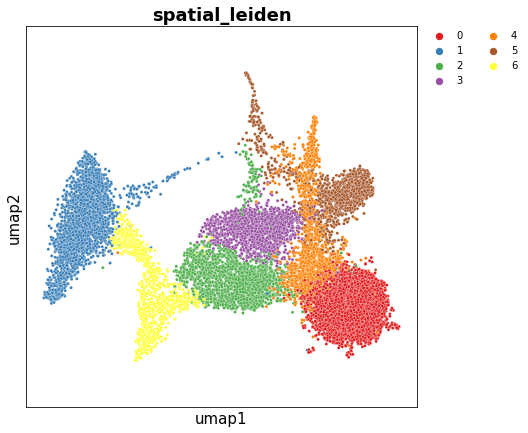

In [50]:
data.plt.umap(res_key='umap', cluster_key='spatial_leiden')

## hotspot

Hotspot is a tool for identifying informative genes (and gene modules) in a single-cell dataset.

Importantly ‘informative’ is decided based on how well a gene’s variation agrees with some cell metric - some similarity mapping between cells.

Genes which are informative are those whose expression varies in similar way among cells which are nearby in the given metric.

In [51]:
data.tl.spatial_hotspot(use_highly_genes=True, use_raw=True, hvg_res_key="raw_highly_variable_genes", 
                        model='normal', n_neighbors=30,n_jobs=20, fdr_threshold=0.05, min_gene_threshold=50, 
                        res_key='spatial_hotspot')


100%|██████████| 2000/2000 [00:59<00:00, 33.60it/s]


Computing pair-wise local correlation on 315 features...


100%|██████████| 49455/49455 [00:14<00:00, 3349.69it/s]


Computing scores for 3 modules...


100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


A convenience method is supplied to plot the results of hs.create_modules

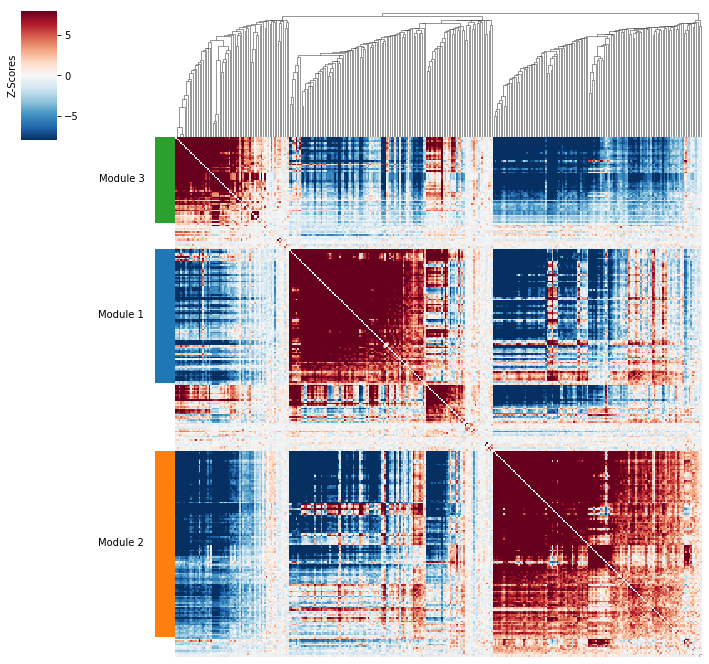

In [52]:
data.plt.hotspot_local_correlations()


Here we can visualize these module scores with spatial position.

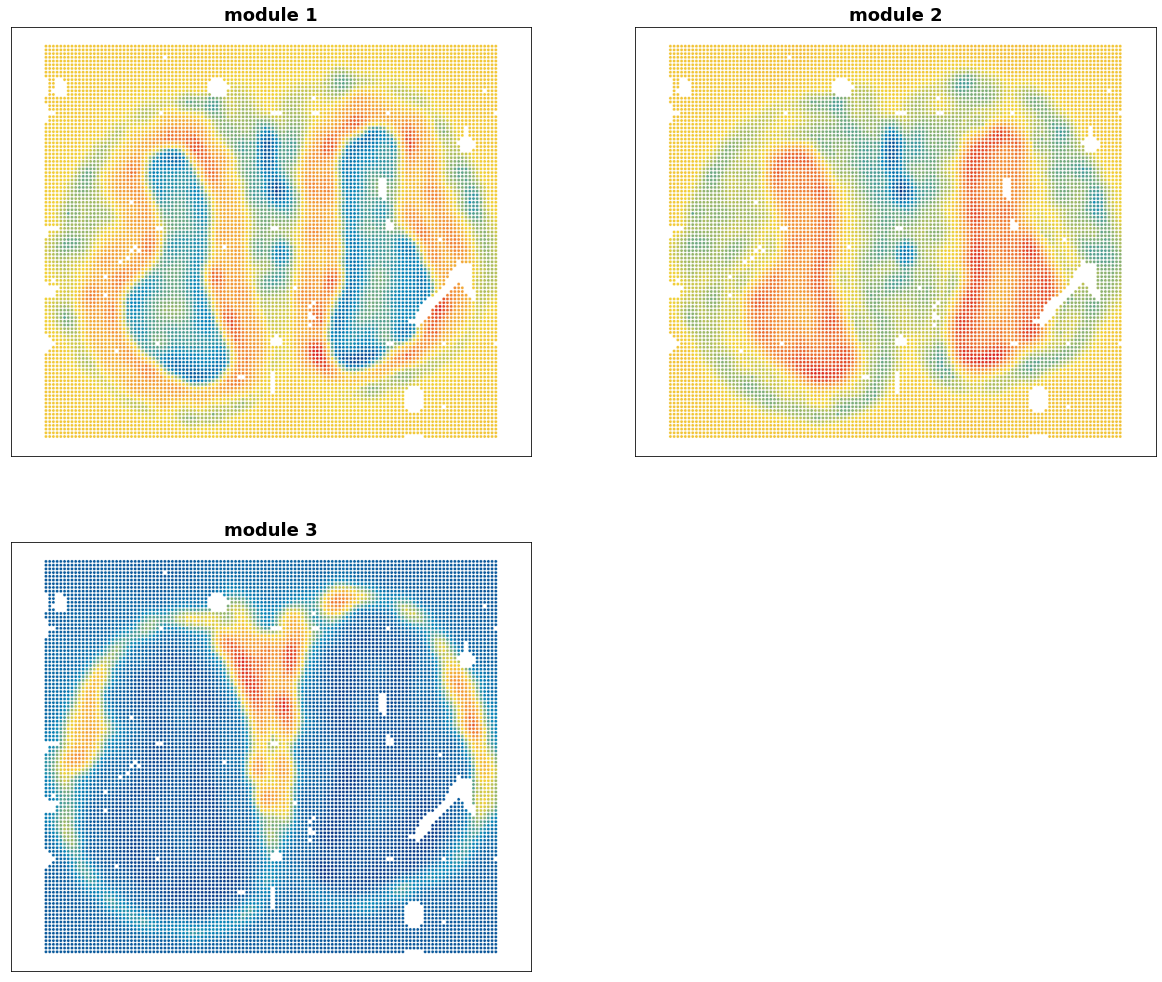

In [53]:
data.plt.hotspot_modules()